In [8]:
import numpy as np
import pandas as pd 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

### Check dataset directory

In [7]:
import os
print(os.listdir("dogs-vs-cats"))

['sampleSubmission.csv', 'test1', 'train']


### Define the constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=64 #image pixel width
IMAGE_HEIGHT=64 #image pixel height
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 #image RGB channel

### Prepare training data

In [9]:
filenames = os.listdir("dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [11]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [12]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### See total image count

<AxesSubplot:>

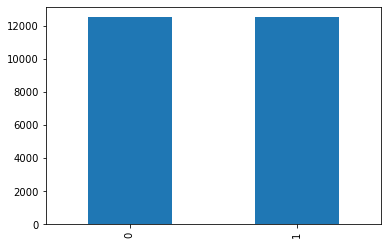

In [13]:
df['category'].value_counts().plot.bar()

### See sample image from dataset

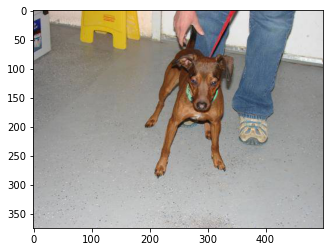

In [17]:
sample = random.choice(filenames)
image = load_img("dogs-vs-cats/train/"+sample)
plt.imshow(image)

## Build model

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

### Show initial weights of the model

In [23]:
print(model.get_weights())

[array([[[[-3.74811366e-02, -1.13993891e-01,  4.22004163e-02,
          -7.75402412e-02,  1.08147383e-01,  1.06530994e-01,
           1.08269989e-01, -9.42204148e-02, -5.87388873e-04,
           1.19243637e-01,  9.81286317e-02,  1.17545500e-01,
           6.65314496e-02, -1.34690106e-01, -9.17099118e-02,
          -1.29892737e-01, -7.85838813e-02, -3.97845134e-02,
           9.57754701e-02, -1.16802916e-01,  9.12659615e-02,
           1.26481429e-01,  4.23238128e-02, -1.44485384e-02,
          -8.52722973e-02, -5.59432805e-03,  1.21761724e-01,
          -7.86173791e-02,  9.73126292e-02,  4.35082912e-02,
          -3.15592438e-02, -7.86751285e-02],
         [-9.87707376e-02, -2.48119012e-02,  5.19686639e-02,
          -7.58752525e-02,  7.94339180e-02,  6.44902587e-02,
          -4.78515103e-02, -8.92464221e-02,  1.35540888e-01,
           9.48418230e-02, -1.64464116e-04, -1.42260641e-02,
          -9.25790593e-02,  2.33915597e-02,  8.72662365e-02,
          -1.02386490e-01,  9.55020636e

## Callbacks

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stopping
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [19]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction
We will reduce the learning rate when then accuracy does not increase for 2 steps

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [21]:
callbacks = [earlystop, learning_rate_reduction]

## Data Preparation
Because we will use an image generator with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [24]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [25]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

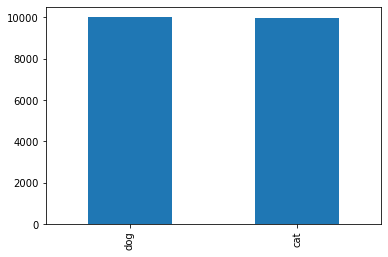

In [26]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

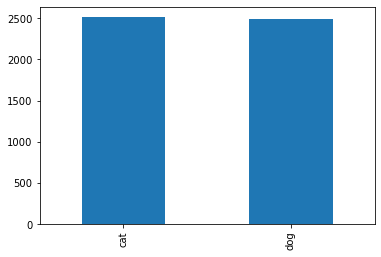

In [27]:
validate_df['category'].value_counts().plot.bar()

In [28]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [32]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [33]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


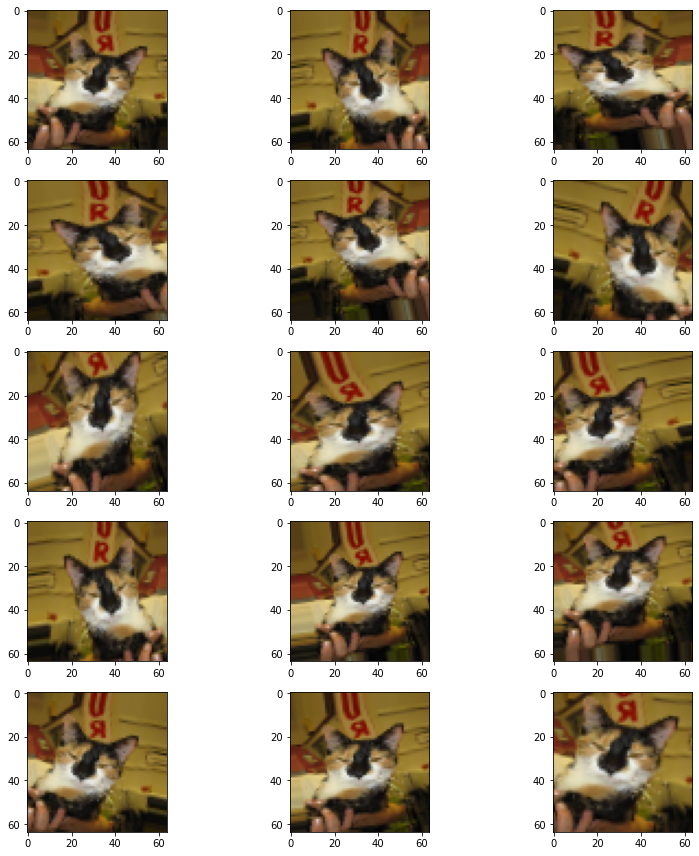

In [34]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Pixels of the image: 12288
Number of arrays: 64
[[[0.07360324 0.08363678 0.09756668]
  [0.08819328 0.10663315 0.12576829]
  [0.09273836 0.11516306 0.14344074]
  ...
  [0.05428446 0.10149767 0.15547337]
  [0.04058893 0.09122602 0.12465844]
  [0.07618251 0.10559893 0.14929375]]

 [[0.0249758  0.03585386 0.04608382]
  [0.05207784 0.06101335 0.0705278 ]
  [0.05772978 0.05846754 0.07211137]
  ...
  [0.0515179  0.09942274 0.1492486 ]
  [0.04339564 0.09193774 0.1247036 ]
  [0.08448222 0.10905714 0.15551853]]

 [[0.01817399 0.02686143 0.033377  ]
  [0.04253622 0.05393175 0.06266199]
  [0.0481026  0.0348264  0.05076763]
  ...
  [0.04875133 0.09734782 0.14302382]
  [0.05169533 0.09539594 0.13092837]
  [0.09061278 0.11251534 0.15686275]]

 ...

 [[0.1176118  0.12937652 0.1568275 ]
  [0.12024114 0.13200584 0.15945682]
  [0.11566561 0.12743032 0.1548813 ]
  ...
  [0.07691696 0.08868167 0.10828952]
  [0.08121003 0.09297474 0.11258259]
  [0.0855031  0.09726781 0.11687565]]

 [[0.10594478 0.1177095  0

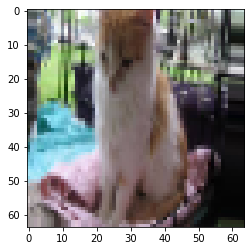

In [47]:
# Show image
for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

# Show number of pixels the number was divided into
for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        print("Pixels of the image:", image.size)
        break
        
# Show the number of arrays
for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        print("Number of arrays:", len(image))
        break

# Show the integer values
for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        print(image)
        break

In [48]:
# Show the integer values
for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        print(image.ndim)
        break

3
